# Notebook 99: Inverse design of wavelength multiplexer

This notebook explores the optimization of a wavelength multiplexer.

This notebook is still in **BETA**.

In [1]:
import numpy as np
import autograd.numpy as npa

import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [2]:
# The two angular frequencies
omega1=2*np.pi*200e12
omega2=2*np.pi*190e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=140
# Number of pixels in y-direction
Ny=140
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
blur_radius=4
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=200.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8

# Number of epochs in the optimization 
Nsteps=50
# Step size for the Adam optimizer
step_size=1e-2

In [3]:
# Projection that drives rho towards a "binarized" design with values either 0 or 1 
def operator_proj(rho, eta=0.5, beta=100, N=1):
    """Density projection
    eta     : Center of the projection between 0 and 1
    beta    : Strength of the projection
    N       : Number of times to apply the projection
    """
    for i in range(N):
        rho =  npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                          npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))
    
    return rho

# Blurring filter that results in smooth features of the structure
# First we define a function to create the kernel
def _create_blur_kernel(radius):
    """Helper function used below for creating the conv kernel"""
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    return  kernel/kernel.sum()

# Then we define the function to apply the operation
def operator_blur(rho, radius=2, N=1):
    """Blur operator implemented via two-dimensional convolution
    radius    : Radius of the circle for the conv kernel filter
    N         : Number of times to apply the filter
    
    Note that depending on the radius, the kernel is not always a
    perfect circle due to "pixelation" / stair casing
    """
    
    kernel = _create_blur_kernel(radius)
    
    for i in range(N):
        # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
        rho = conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]
    
    return rho

def viz_sim(epsr, source1, source2, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'
    """   
    simulation1 = fdfd_ez(omega1, dl, epsr, [Npml, Npml])
    _, _, Ez1 = simulation1.solve(source1)
    simulation2 = fdfd_ez(omega2, dl, epsr, [Npml, Npml])
    _, _, Ez2 = simulation2.solve(source2)

    fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(8,4))
    ceviche.viz.real(Ez1, outline=epsr, ax=ax[0], cbar=False)
    ceviche.viz.real(Ez2, outline=epsr, ax=ax[1], cbar=False)
    ceviche.viz.abs(epsr, ax=ax[2], cmap='Greys')
    for sl in slices:
        ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'r-')
        ax[1].plot(sl.x*np.ones(len(sl.y)), sl.y, 'r-')
    
    ax[0].set_title('$\omega_1$')
    ax[1].set_title('$\omega_2$')
    plt.show()
    return (simulation1, simulation2, ax)

def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(np.float)

def epsr_parameterization(rho, bg_rho, design_region, radius=2, N_blur=1, beta=100, eta=0.5, N_proj=1):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho; Note: this is so the subsequent blur sees the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    rho = operator_blur(rho, radius=radius, N=N_blur)
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)
    
    # Final masking undoes the blurring of the waveguides
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    return epsr_min + (epsr_max-epsr_min) * rho

## Simulate the initial structure



In [4]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5, wg_shift=14):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    rho = np.zeros((Nx, Ny))
    bg_rho = np.zeros((Nx, Ny))
    
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    bg_rho[0:Npml+space,Ny//2-wg_width//2:Ny//2+wg_width//2] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))
    
    # Output waveguide 1
    bg_rho[int(Nx-Npml-space)::,Npml+space+wg_shift:Npml+space+wg_width+wg_shift] = 1
    
    # Output waveguide 2
    bg_rho[int(Nx-Npml-space)::,Ny-Npml-space-wg_width-wg_shift:Ny-Npml-space-wg_shift] = 1
    
    # Output probe slice 1
    output_slice1 = (Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(Npml+space-space_slice+wg_shift, Npml+space+wg_width+space_slice+wg_shift)))
    
    # Output probe slice 2
    output_slice2 = (Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(Ny-Npml-space-wg_width-wg_shift-space_slice, Ny-Npml-space-wg_shift+space_slice)))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    
    # Const init
    rho = design_region * 0.5
    
    # Ranom init
    # np.random.seed(4)
    # rho = design_region * ( 0.5 + 0.001 * np.random.rand(Nx, Ny) )
    # np.random.seed(None)
    # rho = operator_blur(rho, radius=4, N=1)
    # rho = operator_proj(rho, beta=600, N=1)
    # rho = operator_blur(rho, radius=10, N=1)
    
    return rho, bg_rho, design_region, input_slice, output_slice1, output_slice2

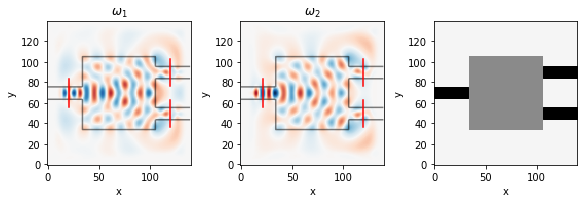

In [5]:
# Initialize the parametrization rho and the design region
rho, bg_rho, design_region, input_slice, output_slice1, output_slice2 = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

# Compute the permittivity from rho_init, including blurring and projection
epsr_init = epsr_parameterization(rho, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)

# Setup source
source1 = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_init, m=1)
source2 = insert_mode(omega2, dl, input_slice.x, input_slice.y, epsr_init, m=1)

# Setup probe
probe1 = insert_mode(omega1, dl, output_slice1.x, output_slice1.y, epsr_init, m=1)
probe2 = insert_mode(omega2, dl, output_slice2.x, output_slice2.y, epsr_init, m=1)

# Simulate initial device
simulation1, simulation2, ax = viz_sim(epsr_init, source1, source2, slices = [input_slice, output_slice1, output_slice2])

## Run the WDM optimization

Epoch:   1/ 50 | Duration: 0.36 secs | Value: 3.275919e-01
Epoch:   2/ 50 | Duration: 0.49 secs | Value: 1.143208e+00
Epoch:   3/ 50 | Duration: 0.38 secs | Value: 4.661856e-01
Epoch:   4/ 50 | Duration: 0.37 secs | Value: 2.172723e-01
Epoch:   5/ 50 | Duration: 0.51 secs | Value: 1.280729e+00
Epoch:   6/ 50 | Duration: 0.47 secs | Value: 1.357871e+00
Epoch:   7/ 50 | Duration: 0.40 secs | Value: 2.363484e+00
Epoch:   8/ 50 | Duration: 0.56 secs | Value: 2.048309e+00
Epoch:   9/ 50 | Duration: 0.50 secs | Value: 2.152814e+00
Epoch:  10/ 50 | Duration: 0.38 secs | Value: 2.413424e+00
Epoch:  11/ 50 | Duration: 0.38 secs | Value: 2.666692e+00
Epoch:  12/ 50 | Duration: 0.37 secs | Value: 2.894419e+00
Epoch:  13/ 50 | Duration: 0.39 secs | Value: 3.081232e+00
Epoch:  14/ 50 | Duration: 0.60 secs | Value: 3.283929e+00
Epoch:  15/ 50 | Duration: 0.38 secs | Value: 3.516492e+00
Epoch:  16/ 50 | Duration: 0.44 secs | Value: 3.637908e+00
Epoch:  17/ 50 | Duration: 0.38 secs | Value: 3.698882e+

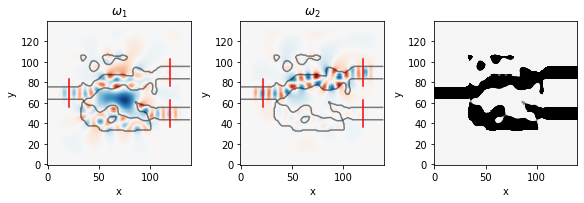

In [51]:
# Define optimization objective
def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))*1e6

def objective(rho):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation1.eps_r = epsr
    simulation2.eps_r = epsr
    
    _, _, Ez1 = simulation1.solve(source1)
    _, _, Ez2 = simulation2.solve(source2)
    return mode_overlap(Ez1, probe1) * mode_overlap(Ez2,probe2)

# Compute the gradient of the objective function using revere-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', step_size=step_size)

# Simulate optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
viz_sim(epsr, source1, source2, slices = [input_slice, output_slice1, output_slice2]);

Epoch:    1/  50 | Duration:   0.26 secs | Objective: -3.326134e-01
Epoch:    2/  50 | Duration:   0.26 secs | Objective: -2.827808e-01
Epoch:    3/  50 | Duration:   0.25 secs | Objective: -5.533697e-01
Epoch:    4/  50 | Duration:   0.26 secs | Objective: -9.938725e-01
Epoch:    5/  50 | Duration:   0.26 secs | Objective: -2.238507e+00
Epoch:    6/  50 | Duration:   0.35 secs | Objective: -1.892817e+00
Epoch:    7/  50 | Duration:   0.39 secs | Objective: -1.507946e+00
Epoch:    8/  50 | Duration:   0.34 secs | Objective: -2.552360e+00
Epoch:    9/  50 | Duration:   0.25 secs | Objective: -2.607048e+00
Epoch:   10/  50 | Duration:   0.25 secs | Objective: -2.525805e+00
Epoch:   11/  50 | Duration:   0.35 secs | Objective: -2.931349e+00
Epoch:   12/  50 | Duration:   0.29 secs | Objective: -3.054385e+00
Epoch:   13/  50 | Duration:   0.31 secs | Objective: -3.628011e+00
Epoch:   14/  50 | Duration:   0.25 secs | Objective: -3.701241e+00
Epoch:   15/  50 | Duration:   0.25 secs | Objec

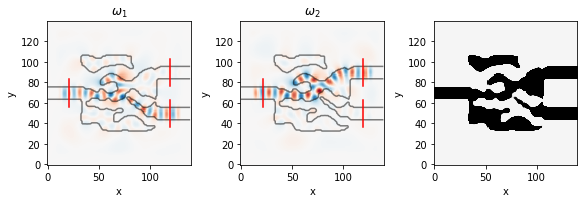

In [68]:
from legume.minimize import Minimize
from autograd import value_and_grad

def beta_it(iteration):
    return 50 + 10*iteration

def of(rho, opt):
    beta = beta_it(opt.iteration)
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation1.eps_r = epsr
    simulation2.eps_r = epsr
    
    _, _, Ez1 = simulation1.solve(source1)
    _, _, Ez2 = simulation2.solve(source2)
    return -mode_overlap(Ez1, probe1) * mode_overlap(Ez2,probe2)

obj_grad = value_and_grad(of, 0)
opt = Minimize(obj_grad, True)
(rho_opt, ofs) = opt.adam(rho.flatten(), Nepochs=Nsteps, step_size=step_size, args=(), pass_self=True)

# Simulate optimal device
rho_optimum = rho_opt.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta_it(Nsteps), eta=eta, N_proj=N_proj)
print("\nFinal beta: ", beta_it(Nsteps))
viz_sim(epsr, source1, source2, slices = [input_slice, output_slice1, output_slice2]);

Epoch:    1/  50 | Duration:   0.73 secs | Objective: -1.207814e+00
Epoch:    2/  50 | Duration:   0.75 secs | Objective: -1.473853e+00
Epoch:    3/  50 | Duration:   0.26 secs | Objective: -2.294627e+00
Epoch:    4/  50 | Duration:   0.59 secs | Objective: -2.492664e+00
Epoch:    5/  50 | Duration:   0.52 secs | Objective: -2.565094e+00
Epoch:    6/  50 | Duration:   0.74 secs | Objective: -2.715520e+00
Epoch:    7/  50 | Duration:   0.63 secs | Objective: -2.936344e+00
Epoch:    8/  50 | Duration:   0.59 secs | Objective: -3.160446e+00
Epoch:    9/  50 | Duration:   0.27 secs | Objective: -3.486948e+00
Epoch:   10/  50 | Duration:   0.28 secs | Objective: -3.712305e+00
Epoch:   11/  50 | Duration:   0.54 secs | Objective: -3.930091e+00
Epoch:   12/  50 | Duration:   0.26 secs | Objective: -4.052590e+00
Epoch:   13/  50 | Duration:   0.26 secs | Objective: -4.164732e+00
Epoch:   14/  50 | Duration:   0.51 secs | Objective: -4.377522e+00
Epoch:   15/  50 | Duration:   0.27 secs | Objec

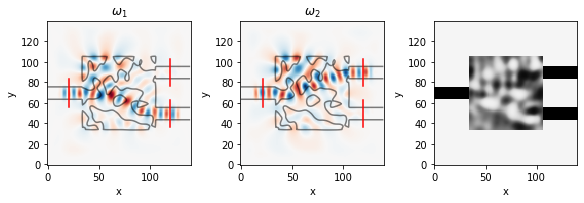

In [65]:
def beta_it(iteration):
    return 50 + 10*iteration

def of(rho, opt):
    beta = beta_it(opt.iteration)
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(rho, bg_rho, design_region, \
                             radius=blur_radius, N_blur=N_blur, beta=beta, eta=eta, N_proj=N_proj)
    simulation1.eps_r = epsr
    simulation2.eps_r = epsr
    
    _, _, Ez1 = simulation1.solve(source1)
    _, _, Ez2 = simulation2.solve(source2)
    return -mode_overlap(Ez1, probe1) * mode_overlap(Ez2,probe2)

obj_grad = value_and_grad(of, 0)
opt = Minimize(obj_grad, True)
(rho_opt, ofs, res) = opt.lbfgs(rho.flatten(), Nepochs=Nsteps, args=(), pass_self=True, res_store=True)

# Simulate optimal device
rho_optimum = rho_opt.reshape((Nx, Ny))
epsr = epsr_parameterization(rho_optimum, bg_rho, design_region, \
                                  radius=blur_radius, N_blur=N_blur, beta=beta_it(res.nit), eta=eta, N_proj=N_proj)
print("\nFinal beta: ", beta_it(res.nit))
viz_sim(epsr, source1, source2, slices = [input_slice, output_slice1, output_slice2]);